## Sensitivity analysis
- Partial correlation coefficient (PCC)
- Random Balance Design - Fourier Amplitude Sensitivity Test (RBD-FAST)

In [ ]:
import os
import yaml

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from SALib.analyze import rbd_fast
from palettable.colorbrewer.sequential import YlGn_9
from palettable.cmocean.sequential import Tempo_10
from palettable.colorbrewer.qualitative import Dark2_4
from palettable.cartocolors.qualitative import Pastel_4

from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype.nass_process import read_nass, nass_summarize
from ideotype.init_params import params_sample
from ideotype.data_process import agg_sims
from ideotype import DATA_PATH

In [2]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_present.yml')
df_extended, df_stuck = parse_mature(df_all)

In [3]:
# Aggregate data
df = df_matured
groups = ['cvar', 'site']
mx_mean = agg_sims(df, groups, 'mean')
mx_variance = agg_sims(df, groups, 'variance')
mx_disp = np.divide(mx_variance, mx_mean)
df_yield_means = pd.DataFrame(mx_mean)
df_yield_vars = pd.DataFrame(mx_disp)

<AxesSubplot:>

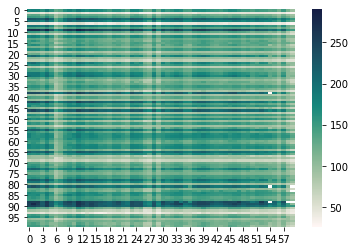

In [4]:
sns.heatmap(df_yield_means, cmap=Tempo_10.mpl_colormap)

In [29]:
sites = list(np.sort(list(set(df_matured.site))))

<BarContainer object of 60 artists>

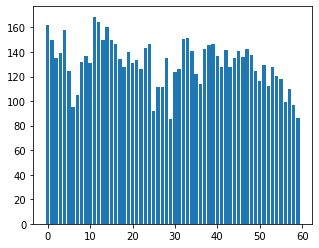

In [32]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(60), df_yield_means.mean())

In [74]:
k = 10
result = np.argpartition(df_yield_means.mean(), k)
select = list(df_yield_means.mean()[result[:k]].index)

In [75]:
sites_lowyield = [sites[item] for item in select]
df_lowyield_sites = df_sites[df_sites.site.isin(sites_lowyield)]

Text(0.5, 1.0, 'low yielding sites')

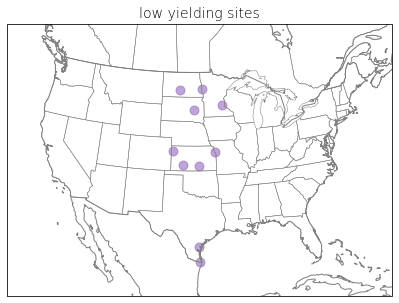

In [79]:
fig = plt.figure(figsize=(7,5))
extent = [-123, -72, 19, 53]

ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

ax.scatter(df_lowyield_sites.lon, df_lowyield_sites.lat, transform = ccrs.PlateCarree(),
           color='tab:purple', s=80, alpha=0.6)
ax.set_title('low yielding sites', fontweight='light', fontsize=14)

### Partial Correlation Coefficient

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

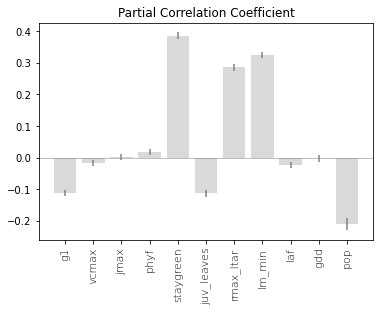

In [14]:
params_list = list(df_params.columns[:-1])
rs = []
ps = []
cis = []

for item in np.arange(11):
    param = params_list[item]
    select = list(np.arange(11))
    select.remove(item)
    params_sub = [params_list[item] for item in select]
    pcc = pg.partial_corr(df_all, x=param, y='dm_ear',
                          x_covar=params_sub)
    rs.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis.append(pcc['CI95%']['pearson'])

errs = [np.round(np.abs(cis[item][0] - cis[item][1]),2) for item in np.arange(len(cis))]

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.bar(params_list, rs, color='#d9d9d9',
       yerr=errs, ecolor='grey')
ax.set_title('Partial Correlation Coefficient')

plt.axhline(y=0, color='grey', linewidth=0.5)
plt.xticks(rotation=90, fontsize=11, weight='light')

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

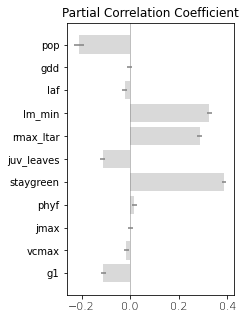

In [21]:
params_list = list(df_params.columns[:-1])
rs = []
ps = []
cis = []

for item in np.arange(11):
    param = params_list[item]
    select = list(np.arange(11))
    select.remove(item)
    params_sub = [params_list[item] for item in select]
    pcc = pg.partial_corr(df_all, x=param, y='dm_ear',
                          x_covar=params_sub)
    rs.append(pcc['r']['pearson'])
    ps.append(pcc['p-val']['pearson'])
    cis.append(pcc['CI95%']['pearson'])

errs = [np.round(np.abs(cis[item][0] - cis[item][1]),2) for item in np.arange(len(cis))]

fig = plt.figure(figsize=(3,5))
ax = fig.add_subplot(1,1,1)
ax.barh(params_list, rs, color='#d9d9d9',
       xerr=errs, ecolor='grey')
ax.set_title('Partial Correlation Coefficient')

plt.axvline(x=0, color='grey', linewidth=0.5)
plt.xticks(fontsize=11, weight='light')

### RBD-FAST
Note: SI values should not be negative, I think this suggests that sample size is not enough.

In [ ]:
problem, param_values = params_sample('present', 100)
df_params = df_params[:100]
ear = df_all.groupby('cvar').mean().dm_ear

X = df_params.to_numpy()
Y = np.array(ear)
Si = rbd_fast.analyze(problem, X, Y, print_to_console=False)

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(1,1,1)
ax.bar(params_list, Si['S1'], color='#d9d9d9')
ax.set_title('RBD-FAST')

plt.axhline(y=0, color='grey', linewidth=0.5)
plt.xticks(rotation=90, fontsize=11, weight='light')

In [132]:
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Where to add in scatter plot type analyses?
Also can't find where the old code is used to plot it..

### Cluster based on site-year climate info
- Treating each site-year as individual samples
- One down side with treating each site-year as individuals is that it's hard to relate to the clustered groups. Can't project back onto a map.
- Can think about tweaking what features to use to cluster sites, but I don't think it'll make a big difference.
- Q: should I pre-process before clustering?

In [224]:
#df_climate = df_all[['temp', 'temp_var', 'vpd', 'rh_var', 'precip', 'precip_var', 'solrad']]
df_climate = df_all[['temp', 'vpd', 'precip']]

kmeans_mod = KMeans(n_clusters=4)
kmeans_mod.fit(df_climate)
y_kmeans = kmeans_mod.predict(df_climate)

df_cluster = df_all.copy()
df_cluster['group'] = y_kmeans

df_km0 = df_cluster.query('group==0')
df_km1 = df_cluster.query('group==1')
df_km2 = df_cluster.query('group==2')
df_km3 = df_cluster.query('group==3')

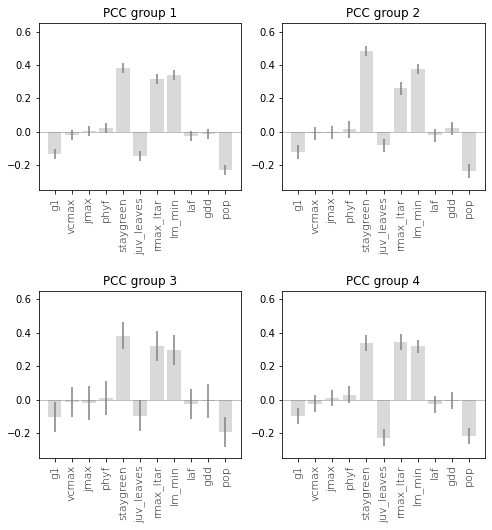

In [225]:
df_kms = [df_km0, df_km1, df_km2, df_km3]
params_list = list(df_params.columns[:-1])

fig = plt.figure(figsize=(8,8))

for num in np.arange(len(df_kms)):
    rs = []
    ps = []
    cis = []
    ax = fig.add_subplot(2,2,num+1)
    
    for item in np.arange(11):
        param = params_list[item]
        select = list(np.arange(11))
        select.remove(item)
        params_sub = [params_list[item] for item in select]
        pcc = pg.partial_corr(df_kms[num], x=param, y='dm_ear',
                              x_covar=params_sub)
        rs.append(pcc['r']['pearson'])
        ps.append(pcc['p-val']['pearson'])
        cis.append(pcc['CI95%']['pearson'])

    errs = [np.round(np.abs(cis[item][0] - cis[item][1]),2) for item in np.arange(len(cis))]

    ax.bar(params_list, rs, color='#d9d9d9',
           yerr=errs, ecolor='grey')
    ax.set_title(f'PCC group {num+1}')
    ax.set_ylim(-0.35, 0.65)

    plt.axhline(y=0, color='grey', linewidth=0.5)
    plt.xticks(rotation=90, fontsize=11, weight='light')

fig.subplots_adjust(wspace=0.2, hspace=0.6)

### Try clustering based on various methods
- k-means clustering based on individual site-years
- k-means clustering based on site
- k-means clustering based on sites + soil info
- manula clustering based on temperature & VPD

### Cluster based on site

In [320]:
#df_climate = df_all[['temp', 'temp_var', 'vpd', 'rh_var', 'precip', 'precip_var', 'solrad']]
df_climate = df_all.groupby('site').mean()[['temp', 'vpd', 'precip']]

kmeans_mod = KMeans(n_clusters=4)
kmeans_mod.fit(df_climate)
y_kmeans = kmeans_mod.predict(df_climate)

df_cluster = df_climate.copy()
df_cluster['group'] = y_kmeans

df_km0 = df_cluster.query('group==0')
df_km1 = df_cluster.query('group==1')
df_km2 = df_cluster.query('group==2')
df_km3 = df_cluster.query('group==3')

df_clustered_sites = pd.merge(df_cluster, df_sites, left_on='site', right_on='site')

TODO: Add soil information to cluster algorithm?

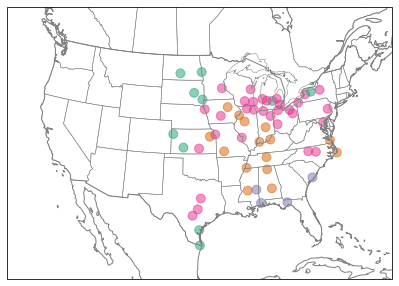

In [326]:
fig = plt.figure(figsize=(7,5))
extent = [-123, -72, 19, 53]

ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df_clustered_sites.lon, df_clustered_sites.lat, 
           c=df_clustered_sites.group, cmap=Dark2_4.mpl_colormap, 
           s=80, alpha=0.5,
           transform=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

In [328]:
test = pd.merge(df_all, df_clustered_sites, left_on='site', right_on='site')

In [330]:
test.query('group==0')

,year,cvar,site,date,jday,time,leaves,mature_lvs,drop_lvs,LA,...,class_y,station_y,state_y,tzone_y,lat_y,lon_y,years_y,area_y,perct_irri_y,texture_y
2600,1961,0,722510,06/17/1961,22449,22,16.0,16,12,152.03,...,1,CORPUS CHRISTI INTL ARPT [UT],TX,-6,27.767,-97.517,21,11177.434686,1.253455,SaClLo
2601,1961,1,722510,06/04/1961,22436,6,21.0,21,15,234.90,...,1,CORPUS CHRISTI INTL ARPT [UT],TX,-6,27.767,-97.517,21,11177.434686,1.253455,SaClLo
2602,1961,2,722510,05/20/1961,22421,14,20.0,20,14,220.42,...,1,CORPUS CHRISTI INTL ARPT [UT],TX,-6,27.767,-97.517,21,11177.434686,1.253455,SaClLo
2603,1961,3,722510,06/02/1961,22434,14,16.0,16,13,119.81,...,1,CORPUS CHRISTI INTL ARPT [UT],TX,-6,27.767,-97.517,21,11177.434686,1.253455,SaClLo
2604,1961,4,722510,06/27/1961,22459,17,12.0,12,10,124.43,...,1,CORPUS CHRISTI INTL ARPT [UT],TX,-6,27.767,-97.517,21,11177.434686,1.253455,SaClLo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32686,1980,95,726540,09/13/1980,29477,18,19.0,19,15,198.54,...,1,HURON REGIONAL ARPT,SD,-6,44.400,-98.217,26,42435.401800,1.447400,Lo
32687,1980,96,726540,08/07/1980,29440,16,11.0,11,9,49.65,...,1,HURON REGIONAL ARPT,SD,-6,44.400,-98.217,26,42435.401800,1.447400,Lo
32688,1980,97,726540,07/28/1980,29430,20,19.0,19,15,176.05,...,1,HURON REGIONAL ARPT,SD,-6,44.400,-98.217,26,42435.401800,1.447400,Lo
32689,1980,98,726540,10/08/1980,29502,18,23.0,23,19,363.29,...,1,HURON REGIONAL ARPT,SD,-6,44.400,-98.217,26,42435.401800,1.447400,Lo
